In [1]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np
import pathlib
np.random.seed(42)

In [2]:
TRAIN = False
# Number of epochs to train for.
EPOCHS = 25
class_names = ['wbpen']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin
        
        class_name = class_names[int(labels[box_num])]
        
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        ) 

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name, 
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image
def discard_pic_without_label(image_paths,label_paths):
    #paths of images
    im=glob.glob(image_paths)
    im.sort()
    im_names=[pathlib.Path(i).stem for i in im]
    #paths of labels
    lb=glob.glob(label_paths)
    lb.sort()
    lb_names=[pathlib.Path(i).stem for i in lb]
    im_new,lb_new=[],[]
    #check if picture has a label
    for ind,name in enumerate(im_names):
        if name in lb_names: 
            index=lb_names.index(name)
            im_new.append(im[ind])
            lb_new.append(lb[index])
    #return only pictures with label
    return [im_new,lb_new]

# Function to plot images with the bounding boxes.
def plot(image_label, num_samples):
    
    all_training_images = image_label[0]
    all_training_labels = image_label[1]

    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

In [5]:
%pwd

'/home/taniel/Projetos_dev/wbpen/yolov5'

In [18]:
# Visualize a few training images.
plot(discard_pic_without_label('./data/train_data/images/train/*',
                                './data/train_data/labels/train/*'),
    num_samples=4
)

ValueError: empty range for randrange() (0, 0, 0)

<Figure size 1500x1200 with 0 Axes>

In [4]:
def monitor_tensorboard():
    %load_ext tensorboard
    %tensorboard --logdir runs/train
    
def set_res_dir():
    # Directory to store results
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

In [6]:
monitor_tensorboard()


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 12177), started 0:52:52 ago. (Use '!kill 12177' to kill it.)

In [17]:
!python train.py --data ./custom_dataset.yaml --weights runs/train/result_7/weights/last.pt --img 640 --epochs 40 --batch-size 2 --name result_


train: weights=runs/train/result_7/weights/last.pt, cfg=, data=./custom_dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=40, batch_size=2, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=result_, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 1 commit. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.2-154-g999482b Python-3.9.13 torch-1.12.1 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t

                 Class     Images  Instances          P          R      mAP50   
                   all         12         30      0.601      0.533      0.605      0.256

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
       9/39         0G    0.05428    0.01795          0          2        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         12         30      0.651        0.5      0.638      0.265

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      10/39         0G    0.05343    0.02313          0          9        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         12         30      0.548      0.667      0.587      0.203

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      11/39         0G    0.04877    0.02405          0          3        640: 1
          

      33/39         0G    0.03894    0.02468          0          5        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         12         30      0.915      0.719      0.839      0.349

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      34/39         0G    0.03786    0.02146          0          7        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         12         30      0.864      0.733      0.843      0.342

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      35/39         0G    0.03834    0.02309          0          1        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         12         30      0.864      0.733      0.843      0.342

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      36/3

In [8]:
# Function to show validation predictions saved during training.
def show_valid_results(RES_DIR):
    !ls runs/train/{RES_DIR}
    EXP_PATH = f"runs/train/{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()
        
# Helper function for inference on images.
def inference(RES_DIR, data_path):
    # Directory to store inference results.
    infer_dir_count = len(glob.glob('runs/detect/*'))
    print(f"Current number of inference detection directories: {infer_dir_count}")
    INFER_DIR = f"inference_{infer_dir_count+1}"
    print(INFER_DIR)
    # Inference on images.
    !python detect.py --weights runs/train/{RES_DIR}/weights/best.pt \
    --source {data_path} --name {INFER_DIR}
    return INFER_DIR

def visualize(INFER_DIR):
# Visualize inference images.
    INFER_PATH = f"runs/detect/{INFER_DIR}"
    infer_images = glob.glob(f"{INFER_PATH}/*.jpg")
    print(infer_images)
    for pred_image in infer_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(7, 4))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

confusion_matrix.png
events.out.tfevents.1663850977.taniel-Aspire-A315-23G.13499.0
F1_curve.png
hyp.yaml
labels_correlogram.jpg
labels.jpg
opt.yaml
P_curve.png
PR_curve.png
R_curve.png
results.csv
results.png
train_batch0.jpg
train_batch1.jpg
train_batch2.jpg
val_batch0_labels.jpg
val_batch0_pred.jpg
val_batch1_labels.jpg
val_batch1_pred.jpg
val_batch2_labels.jpg
val_batch2_pred.jpg
weights
['runs/train/result_7/val_batch1_pred.jpg', 'runs/train/result_7/val_batch2_pred.jpg', 'runs/train/result_7/val_batch0_pred.jpg']


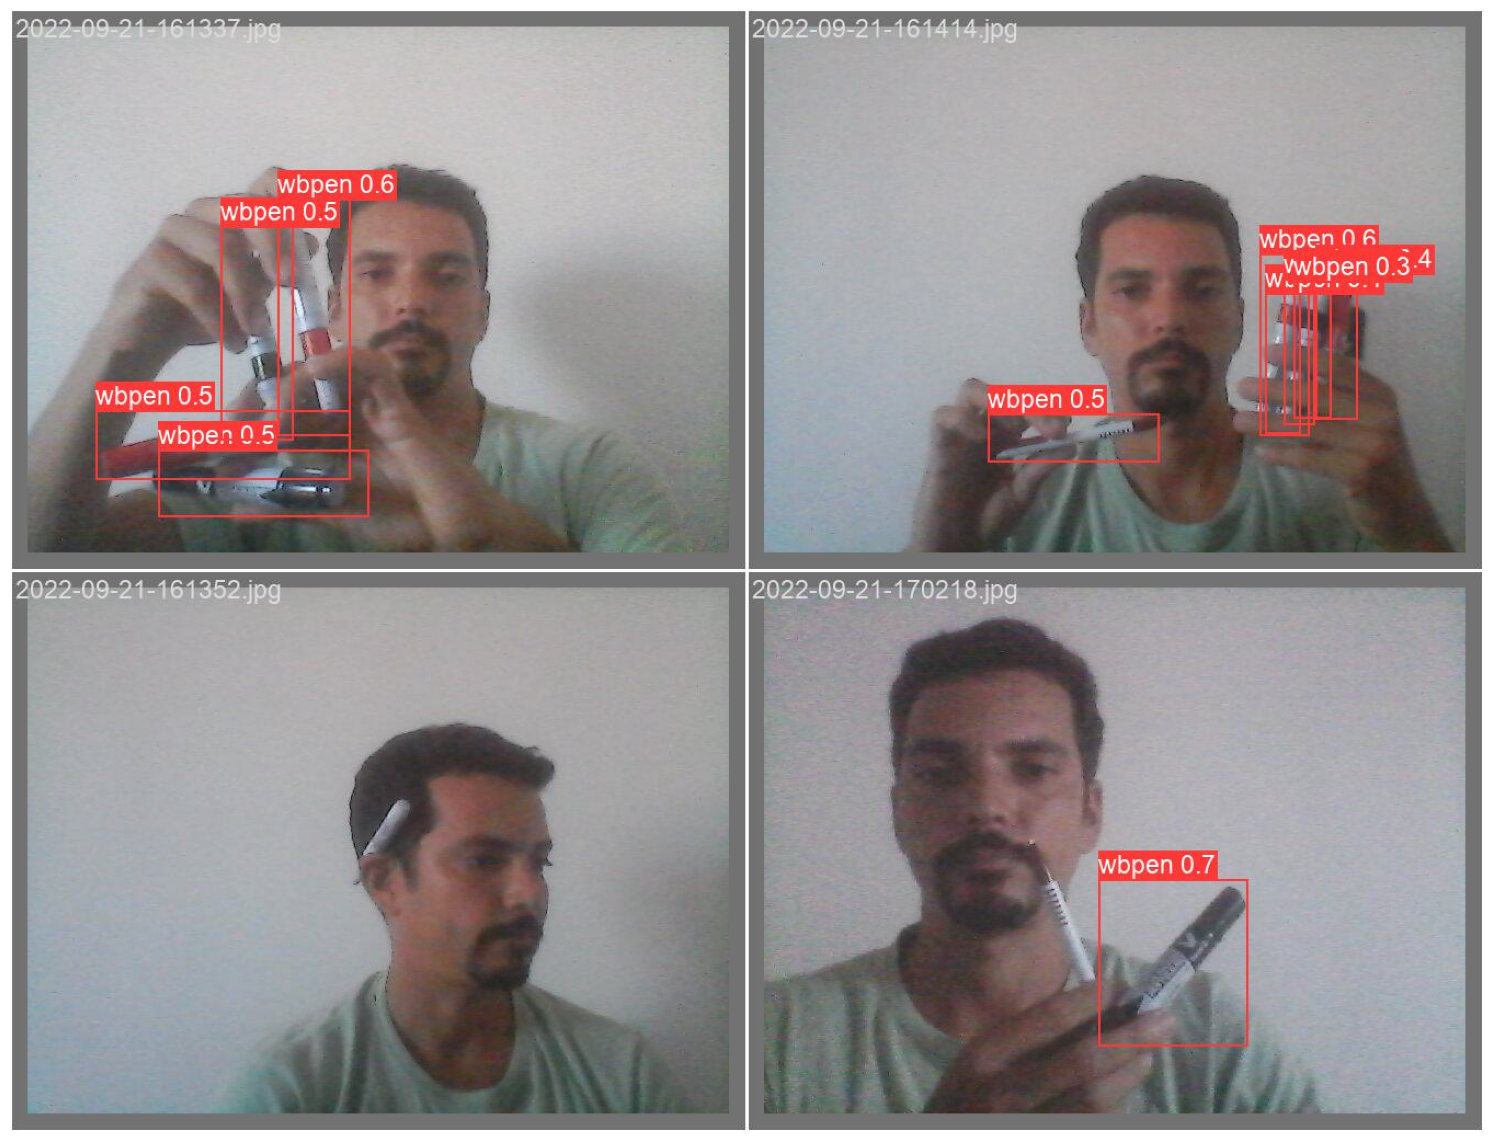

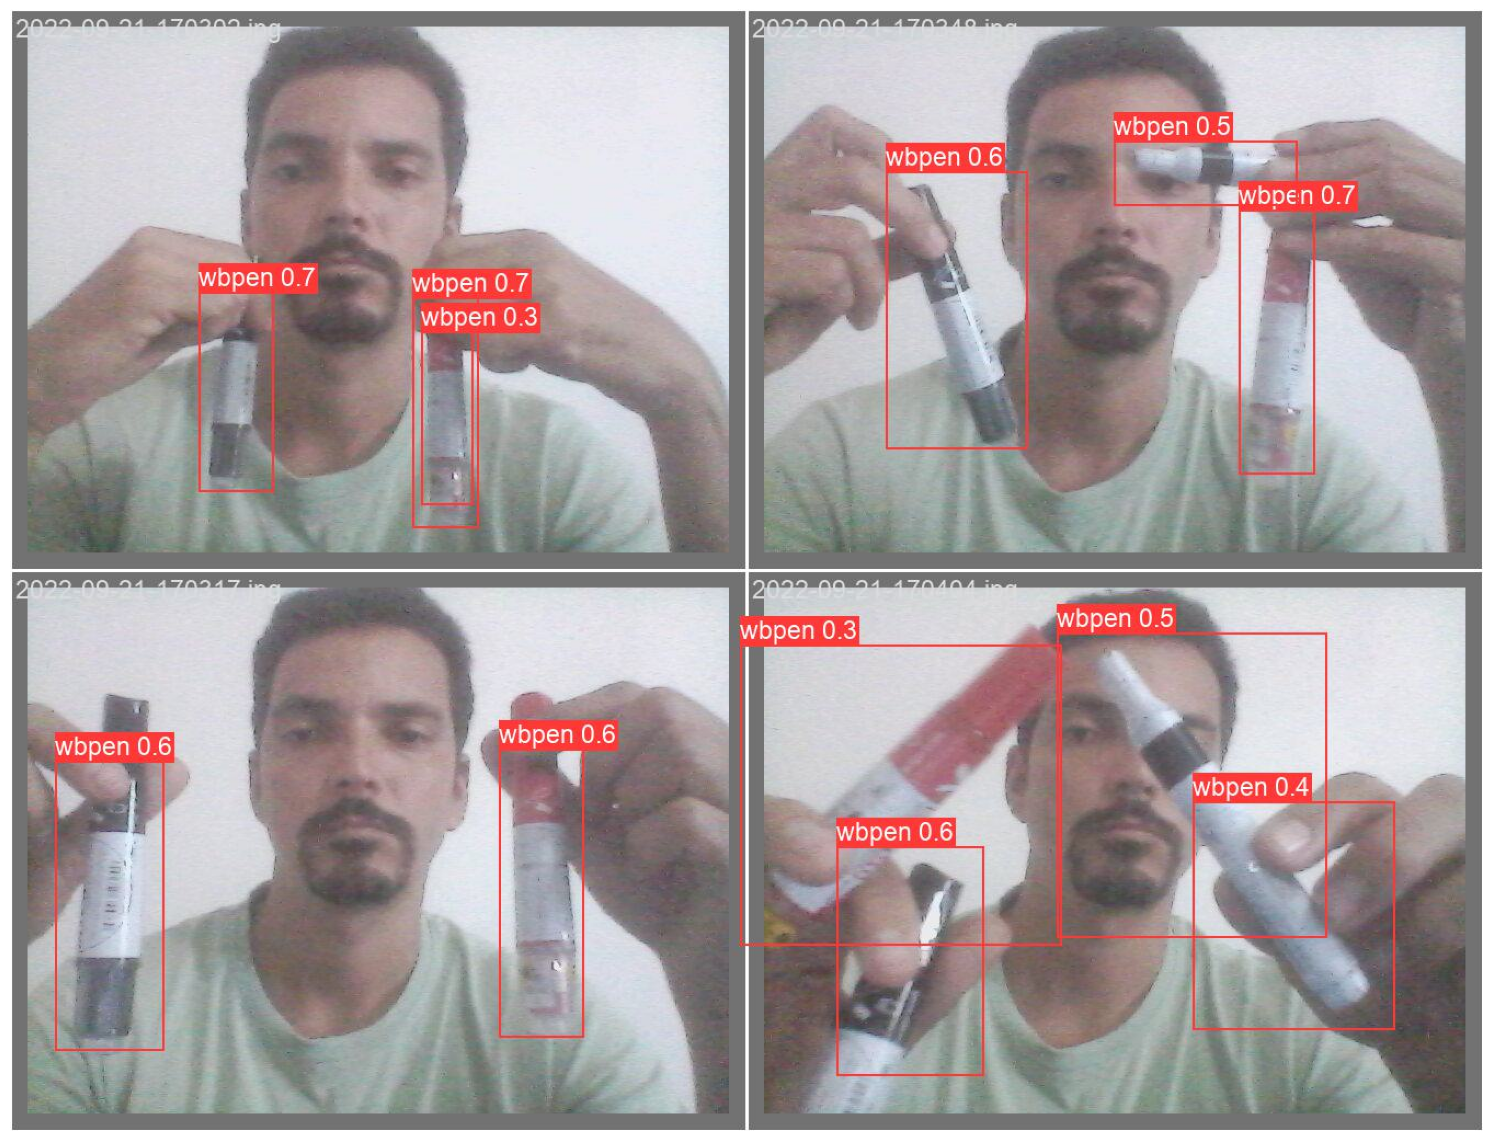

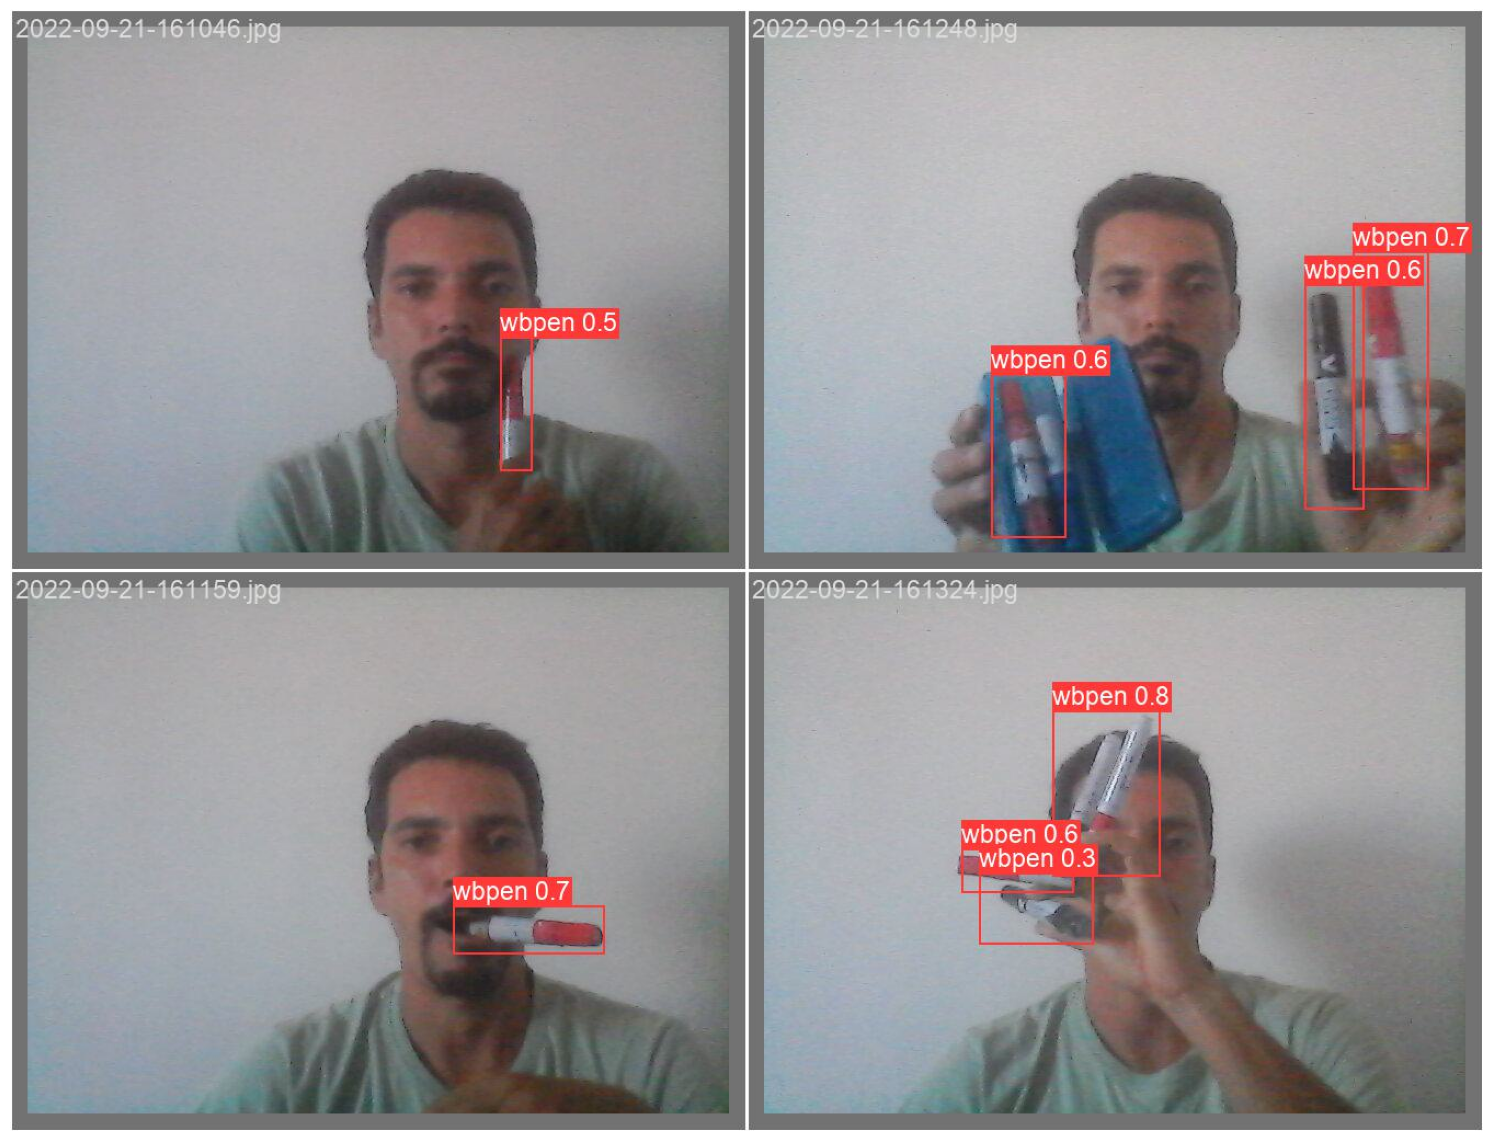

In [9]:
show_valid_results('result_7')

In [10]:
RES_DIR='result_7'

# Inference on images.
IMAGE_INFER_DIR = inference(RES_DIR, './data/infer_images')

Current number of inference detection directories: 2
inference_3
detect: weights=['runs/train/result_7/weights/best.pt'], source=./data/infer_images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=inference_3, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-154-g999482b Python-3.9.13 torch-1.12.1 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/5 /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_images/2022-09-21-161149.jpg: 480x640 1 wbpen, 240.1ms
image 2/5 /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_images/2022-09-21-161240.jpg: 480x640 4 wbpens, 240.2ms
image 3/5 /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_images/

['runs/detect/inference_3/2022-09-21-161149.jpg', 'runs/detect/inference_3/2022-09-21-200755.jpg', 'runs/detect/inference_3/2022-09-21-161318.jpg', 'runs/detect/inference_3/2022-09-21-161240.jpg', 'runs/detect/inference_3/2022-09-21-161253.jpg']


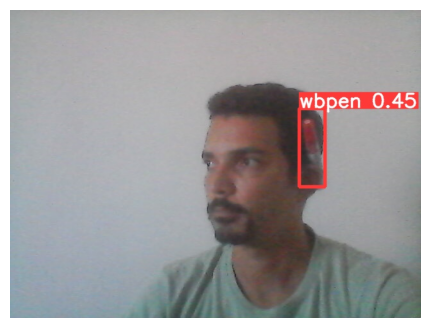

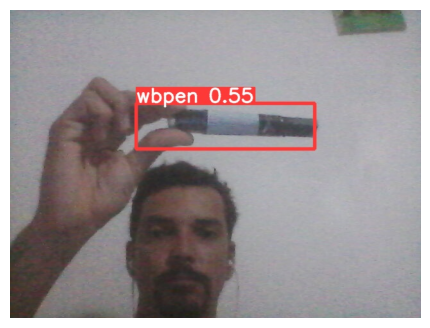

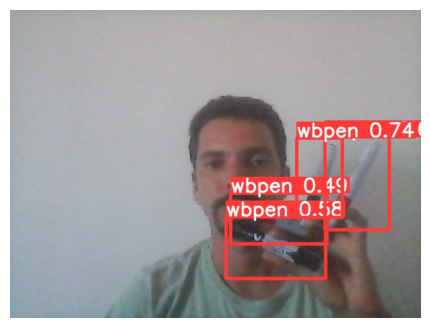

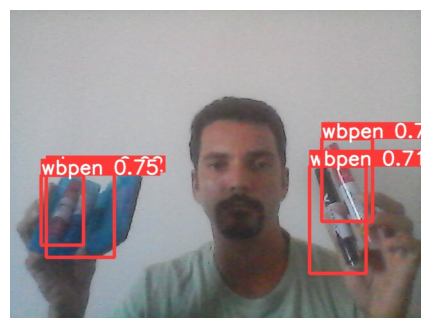

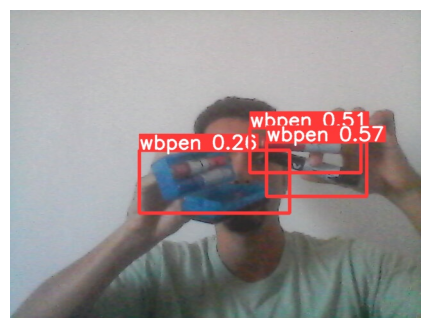

In [11]:
visualize(IMAGE_INFER_DIR)

In [12]:
inference(RES_DIR, './data/infer_video')

Current number of inference detection directories: 3
inference_4
detect: weights=['runs/train/result_7/weights/best.pt'], source=./data/infer_video, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=inference_4, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-154-g999482b Python-3.9.13 torch-1.12.1 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
video 1/1 (1/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 (no detections), 273.4ms
video 1/1 (2/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 (no detections), 253.7ms
video 1/1 (3/769) /home/taniel/Projetos

video 1/1 (60/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 238.5ms
video 1/1 (61/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 220.8ms
video 1/1 (62/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 207.9ms
video 1/1 (63/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 215.4ms
video 1/1 (64/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 252.8ms
video 1/1 (65/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 226.1ms
video 1/1 (66/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 208.9ms
video 1/1 (67/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 191.2ms
video 1/1 (68/76

video 1/1 (126/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 (no detections), 209.6ms
video 1/1 (127/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 (no detections), 230.3ms
video 1/1 (128/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 (no detections), 213.9ms
video 1/1 (129/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 (no detections), 263.4ms
video 1/1 (130/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 (no detections), 215.5ms
video 1/1 (131/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 216.7ms
video 1/1 (132/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 206.7ms
video 1/1 (133/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-16401

video 1/1 (192/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 4 wbpens, 205.5ms
video 1/1 (193/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 4 wbpens, 206.1ms
video 1/1 (194/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 4 wbpens, 202.4ms
video 1/1 (195/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 4 wbpens, 209.4ms
video 1/1 (196/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 3 wbpens, 206.9ms
video 1/1 (197/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 3 wbpens, 271.5ms
video 1/1 (198/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 3 wbpens, 228.0ms
video 1/1 (199/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 2 wbpens, 239.4ms


video 1/1 (258/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 322.0ms
video 1/1 (259/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 272.8ms
video 1/1 (260/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 255.7ms
video 1/1 (261/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 254.9ms
video 1/1 (262/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 312.3ms
video 1/1 (263/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 262.6ms
video 1/1 (264/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 261.6ms
video 1/1 (265/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 254.8ms
video 1/

video 1/1 (324/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 249.9ms
video 1/1 (325/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 266.5ms
video 1/1 (326/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 308.8ms
video 1/1 (327/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 256.2ms
video 1/1 (328/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 246.2ms
video 1/1 (329/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 3 wbpens, 237.5ms
video 1/1 (330/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 3 wbpens, 289.1ms
video 1/1 (331/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 2 wbpens, 247.2ms
video

video 1/1 (390/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 3 wbpens, 214.0ms
video 1/1 (391/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 3 wbpens, 223.9ms
video 1/1 (392/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 3 wbpens, 216.0ms
video 1/1 (393/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 3 wbpens, 213.7ms
video 1/1 (394/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 3 wbpens, 252.0ms
video 1/1 (395/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 3 wbpens, 215.2ms
video 1/1 (396/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 3 wbpens, 214.8ms
video 1/1 (397/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 3 wbpens, 245.4ms


video 1/1 (456/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 2 wbpens, 219.4ms
video 1/1 (457/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 2 wbpens, 216.4ms
video 1/1 (458/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 3 wbpens, 225.4ms
video 1/1 (459/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 3 wbpens, 214.2ms
video 1/1 (460/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 3 wbpens, 224.4ms
video 1/1 (461/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 3 wbpens, 212.2ms
video 1/1 (462/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 3 wbpens, 233.9ms
video 1/1 (463/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 3 wbpens, 214.9ms


video 1/1 (522/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 3 wbpens, 243.0ms
video 1/1 (523/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 3 wbpens, 211.3ms
video 1/1 (524/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 3 wbpens, 226.6ms
video 1/1 (525/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 5 wbpens, 272.3ms
video 1/1 (526/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 5 wbpens, 235.0ms
video 1/1 (527/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 3 wbpens, 211.8ms
video 1/1 (528/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 3 wbpens, 235.6ms
video 1/1 (529/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 2 wbpens, 246.0ms


video 1/1 (588/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 2 wbpens, 244.2ms
video 1/1 (589/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 209.8ms
video 1/1 (590/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 208.9ms
video 1/1 (591/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 2 wbpens, 211.0ms
video 1/1 (592/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 2 wbpens, 213.4ms
video 1/1 (593/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 2 wbpens, 204.8ms
video 1/1 (594/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 2 wbpens, 212.0ms
video 1/1 (595/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 2 wbpens, 229.4ms
vi

video 1/1 (653/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 (no detections), 292.4ms
video 1/1 (654/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 (no detections), 210.8ms
video 1/1 (655/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 (no detections), 231.4ms
video 1/1 (656/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 (no detections), 214.5ms
video 1/1 (657/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 (no detections), 207.9ms
video 1/1 (658/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 208.4ms
video 1/1 (659/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 253.7ms
video 1/1 (660/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-16401

video 1/1 (719/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 262.4ms
video 1/1 (720/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 273.7ms
video 1/1 (721/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 268.7ms
video 1/1 (722/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 269.6ms
video 1/1 (723/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 2 wbpens, 308.5ms
video 1/1 (724/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 2 wbpens, 359.8ms
video 1/1 (725/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 1 wbpen, 263.5ms
video 1/1 (726/769) /home/taniel/Projetos_dev/wbpen/yolov5/data/infer_video/2022-09-21-164017.mp4: 480x640 2 wbpens, 370.8ms
video

'inference_4'

train: weights=runs/train/result_6/weights/best.pt, cfg=, data=./custom_dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=2, batch_size=2, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=result_, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 1 commit. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.2-154-g999482b Python-3.9.13 torch-1.12.1 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=

In [16]:
!python train.py --resume runs/train/result_7/weights/last.pt --img 640 --epochs 4  --batch-size 2 

train: weights=yolov5s.pt, cfg=, data=data/coco128.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=4, batch_size=2, imgsz=640, rect=False, resume=runs/train/result_7/weights/last.pt, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 1 commit. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.2-154-g999482b Python-3.9.13 torch-1.12.1 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2